In [1]:
import tensorflow as tf
from keras import backend as K 
import keras

# Import all the necessary libraries
import os
import datetime 
import glob                                           #filename pattern matching
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Skimage
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
import skimage.exposure  
from skimage import draw

# train and test split
from sklearn.model_selection import train_test_split

# For data augmentation and callbacks
from keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, LearningRateScheduler

from segmentation_model import unet_model
from segmentation_model import mean_iou, dice_coef, costum_dice_loss

from segmentation_data import X_train_1,Y_train_1, X_train_2,Y_train_2
from segmentation_data import X_test_unlabelled
from segmentation_data import img_height, img_width

D:\anaconda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
print('X_train_1: ', X_train_1.shape, X_train_1.dtype)
print('Y_train_1: ', Y_train_1.shape, Y_train_1.dtype)

print('X_train_2: ', X_train_2.shape, X_train_2.dtype)
print('Y_train_2: ', Y_train_2.shape, Y_train_2.dtype)

print('X_test_unlabelled: ', X_test_unlabelled.shape, X_test_unlabelled.dtype)

X_train_1:  (50, 128, 128, 1) uint8
Y_train_1:  (50, 128, 128, 1) float64
X_train_2:  (50, 128, 128, 1) uint8
Y_train_2:  (50, 128, 128, 1) float64
X_test_unlabelled:  (470, 128, 128, 1) uint8


In [3]:
def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Log-loss (cost function)"}
    if x in translations:
        return translations[x]
    else:
        return x
    
class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)
            
            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center left')
        
        plt.tight_layout()
        plt.show();

def scheduler(epoch):
    # 前多少个epochs先预热一下
    if epoch == 30:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 10)
        print("lr changed to {}".format(lr * 10))
        
    # 每隔固定个epoch，学习率减小为原来的1/2
    if epoch % 80 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.1)
        print("lr changed to {}".format(lr * 0.1))
    return K.get_value(model.optimizer.lr)

In [4]:
# Runtime data augmentation
def get_train_test_augmented(X_data, Y_data, validation_split=0.25, batch_size=32, seed=42):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=10.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=False,
                         fill_mode='reflect')  #use 'constant'??


    # Train data generator, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)    # 只要用同一个seed就能有一样的augmentation
    Y_datagen.fit(Y_train, augment=True, seed=seed)    # augment: Whether to fit on randomly augmented samples.
     
    
    # Test data generator, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)  
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    
    # generates batches of augmented data by using .flow
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
    
    X_val_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_val_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    val_generator = zip(X_val_augmented, Y_val_augmented)
    
    return train_generator, val_generator

# central mask
## model

In [5]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True) # lr设置成0.1太大 loss会由于bce那一部分梯度爆炸
#optimizer = keras.optimizers.Adam(lr=0.001, decay=1e-6)
loss      = costum_dice_loss
metrics   = [mean_iou]

input_shape = (img_height, img_width)
model = unet_model(input_shape)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
#model.summary()

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [ ]:
load_weights = False
if load_weights:
    model.load_weights(filepath="./weights_unet1.hdf5")

In [6]:
# train 
log_dir = './segmentation_logs'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
    
# callbacks
plot_losses = PlotLosses(figsize=(16, 4))
checkpoint = ModelCheckpoint(filepath=os.path.join(log_dir,"./weights_unet1.hdf5"), verbose=1, monitor='val_loss', save_best_only=True)
#checkpoint = ModelCheckpoint(filepath=os.path.join(log_dir,"./weights_unet1.hdf5"), verbose=1)
reduce_lr = LearningRateScheduler(scheduler) 

# hyperparameters
epochs = 240
batch_size = 2

seed= 42
steps_per_epoch = 20
validation_split = 0.3
validation_steps = round(X_train_1.shape[0] * validation_split / batch_size)

#Training with augmentation and visualization
train_generator, val_generator = get_train_test_augmented(X_data=X_train_1, 
                                                          Y_data=Y_train_1, 
                                                          validation_split=validation_split, 
                                                          batch_size=batch_size, 
                                                          seed=seed)
history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=epochs, 
                              verbose=1, 
                              #callbacks=[plot_losses, checkpoint, reduce_lr],
                              callbacks=[checkpoint, reduce_lr],
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              shuffle=True)

Epoch 1/240
20/20 [==============================] - 5s 234ms/step - loss: 0.9933 - mean_iou: 0.4246 - val_loss: 0.3412 - val_mean_iou: 0.4762

Epoch 00001: val_loss improved from inf to 0.34117, saving model to ./log\./weights_unet1.hdf5
Epoch 2/240
20/20 [==============================] - 3s 155ms/step - loss: 0.1856 - mean_iou: 0.4746 - val_loss: 0.1282 - val_mean_iou: 0.4737

Epoch 00002: val_loss improved from 0.34117 to 0.12823, saving model to ./log\./weights_unet1.hdf5
Epoch 3/240
20/20 [==============================] - 3s 133ms/step - loss: 0.0819 - mean_iou: 0.4745 - val_loss: 0.0896 - val_mean_iou: 0.4754

Epoch 00003: val_loss improved from 0.12823 to 0.08964, saving model to ./log\./weights_unet1.hdf5
Epoch 4/240
20/20 [==============================] - 3s 131ms/step - loss: 0.0635 - mean_iou: 0.4758 - val_loss: 0.0199 - val_mean_iou: 0.4765

Epoch 00004: val_loss improved from 0.08964 to 0.01985, saving model to ./log\./weights_unet1.hdf5
Epoch 5/240
20/20 [=============

20/20 [==============================] - 3s 126ms/step - loss: -0.7115 - mean_iou: 0.6824 - val_loss: -0.7978 - val_mean_iou: 0.6832

Epoch 00078: val_loss did not improve from -0.87023
Epoch 79/240
20/20 [==============================] - 2s 110ms/step - loss: -0.7321 - mean_iou: 0.6840 - val_loss: -0.6908 - val_mean_iou: 0.6848

Epoch 00079: val_loss did not improve from -0.87023
Epoch 80/240
20/20 [==============================] - 2s 110ms/step - loss: -0.7454 - mean_iou: 0.6856 - val_loss: -0.7782 - val_mean_iou: 0.6864

Epoch 00080: val_loss did not improve from -0.87023
Epoch 81/240
lr changed to 0.0010000000707805158
20/20 [==============================] - 2s 111ms/step - loss: -0.7353 - mean_iou: 0.6870 - val_loss: -0.8229 - val_mean_iou: 0.6876

Epoch 00081: val_loss did not improve from -0.87023
Epoch 82/240
20/20 [==============================] - 2s 109ms/step - loss: -0.7351 - mean_iou: 0.6884 - val_loss: -0.7196 - val_mean_iou: 0.6891

Epoch 00082: val_loss did not impr

20/20 [==============================] - 2s 110ms/step - loss: -0.7512 - mean_iou: 0.7273 - val_loss: -0.9096 - val_mean_iou: 0.7276

Epoch 00119: val_loss improved from -0.87023 to -0.90961, saving model to ./log\./weights_unet1.hdf5
Epoch 120/240
20/20 [==============================] - 2s 102ms/step - loss: -0.7661 - mean_iou: 0.7280 - val_loss: -0.7356 - val_mean_iou: 0.7284

Epoch 00120: val_loss did not improve from -0.90961
Epoch 121/240
20/20 [==============================] - 2s 101ms/step - loss: -0.7696 - mean_iou: 0.7288 - val_loss: -0.8153 - val_mean_iou: 0.7291

Epoch 00121: val_loss did not improve from -0.90961
Epoch 122/240
20/20 [==============================] - 3s 126ms/step - loss: -0.7444 - mean_iou: 0.7295 - val_loss: -0.7585 - val_mean_iou: 0.7298

Epoch 00122: val_loss did not improve from -0.90961
Epoch 123/240
20/20 [==============================] - 2s 118ms/step - loss: -0.7740 - mean_iou: 0.7302 - val_loss: -0.8491 - val_mean_iou: 0.7306

Epoch 00123: val_

20/20 [==============================] - 3s 128ms/step - loss: -0.7564 - mean_iou: 0.7506 - val_loss: -0.7830 - val_mean_iou: 0.7508

Epoch 00160: val_loss did not improve from -0.90961
Epoch 161/240
lr changed to 0.00010000000474974513
20/20 [==============================] - 3s 159ms/step - loss: -0.7504 - mean_iou: 0.7510 - val_loss: -0.8021 - val_mean_iou: 0.7513

Epoch 00161: val_loss did not improve from -0.90961
Epoch 162/240
20/20 [==============================] - 2s 102ms/step - loss: -0.7653 - mean_iou: 0.7515 - val_loss: -0.7396 - val_mean_iou: 0.7517

Epoch 00162: val_loss did not improve from -0.90961
Epoch 163/240
20/20 [==============================] - 2s 99ms/step - loss: -0.7749 - mean_iou: 0.7519 - val_loss: -0.7298 - val_mean_iou: 0.7521

Epoch 00163: val_loss did not improve from -0.90961
Epoch 164/240
20/20 [==============================] - 2s 100ms/step - loss: -0.7670 - mean_iou: 0.7523 - val_loss: -0.8042 - val_mean_iou: 0.7526

Epoch 00164: val_loss did not 

20/20 [==============================] - 2s 118ms/step - loss: -0.7580 - mean_iou: 0.7652 - val_loss: -0.8077 - val_mean_iou: 0.7653

Epoch 00201: val_loss did not improve from -0.90961
Epoch 202/240
20/20 [==============================] - 2s 100ms/step - loss: -0.7715 - mean_iou: 0.7655 - val_loss: -0.5670 - val_mean_iou: 0.7656

Epoch 00202: val_loss did not improve from -0.90961
Epoch 203/240
20/20 [==============================] - 2s 101ms/step - loss: -0.7747 - mean_iou: 0.7658 - val_loss: -0.7085 - val_mean_iou: 0.7659

Epoch 00203: val_loss did not improve from -0.90961
Epoch 204/240
20/20 [==============================] - 2s 99ms/step - loss: -0.7762 - mean_iou: 0.7661 - val_loss: -0.7057 - val_mean_iou: 0.7662

Epoch 00204: val_loss did not improve from -0.90961
Epoch 205/240
20/20 [==============================] - 2s 106ms/step - loss: -0.7555 - mean_iou: 0.7663 - val_loss: -0.8072 - val_mean_iou: 0.7665

Epoch 00205: val_loss did not improve from -0.90961
Epoch 206/240
2

## draw figures 


history lr:


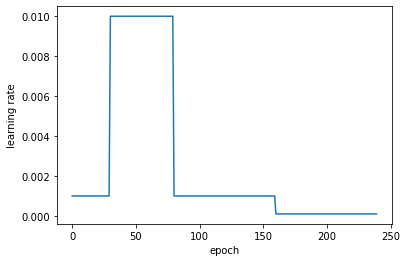

In [7]:
print('\nhistory lr:')
plt.figure()
plt.plot(np.arange(epochs), np.array(history.history['lr']))
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()


history val_loss:


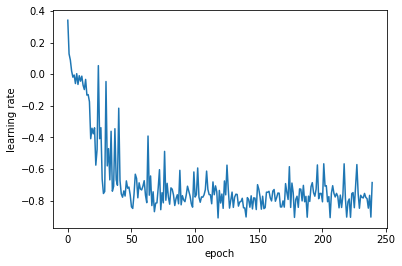

In [8]:
print('\nhistory val_loss:')
plt.figure()
plt.plot(np.arange(epochs), np.array(history.history['val_loss']))
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()


history val_mean_iou:


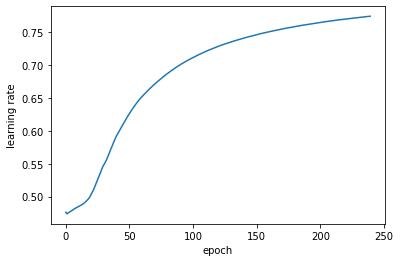

In [9]:
print('\nhistory val_mean_iou:')
plt.figure()
plt.plot(np.arange(epochs), np.array(history.history['val_mean_iou']))
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()

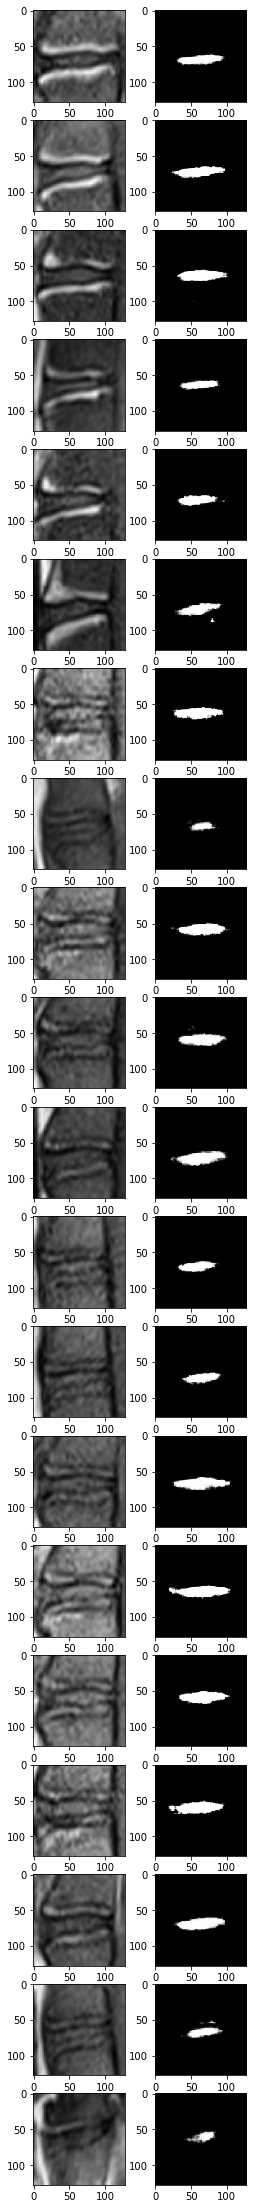

In [11]:
Y_pred = model.predict(X_test_unlabelled)
X_test_show = np.squeeze(X_test_unlabelled)
Y_pred_show = np.squeeze(Y_pred)

plt.figure(figsize=(4,40))
for i in range(20):
    plt.subplot(20,2,2*(i+1)-1)
    plt.imshow(X_test_show[i,:,:],cmap = 'gray')
    plt.subplot(20,2,2*(i+1))
    plt.imshow(Y_pred_show[i,:,:],cmap = 'gray')
plt.show()

# sides mask
## model

In [15]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True) # lr设置成0.1太大 loss会由于bce那一部分梯度爆炸
#optimizer = keras.optimizers.Adam(lr=0.001, decay=1e-6)
loss      = costum_dice_loss
metrics   = [mean_iou]

input_shape = (img_height, img_width)
model2 = unet_model(input_shape)
model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
#model.summary()

In [16]:
load_weights = False
if load_weights:
    model2.load_weights(filepath="./weights_unet2.hdf5")

In [17]:
# train 
log_dir = './log'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
    
# callbacks
plot_losses = PlotLosses(figsize=(16, 4))
checkpoint = ModelCheckpoint(filepath=os.path.join(log_dir,"./weights_unet2.hdf5"), verbose=1, monitor='val_loss', save_best_only=True)
#checkpoint = ModelCheckpoint(filepath=os.path.join(log_dir,"./weights_unet2.hdf5"), verbose=1)
reduce_lr = LearningRateScheduler(scheduler) 

# hyperparameters
epochs = 240
batch_size = 2

seed= 42
steps_per_epoch = 20
validation_split = 0.3
validation_steps = round(X_train_1.shape[0] * validation_split / batch_size)

#Training with augmentation and visualization
train_generator, val_generator = get_train_test_augmented(X_data=X_train_2, 
                                                          Y_data=Y_train_2, 
                                                          validation_split=validation_split, 
                                                          batch_size=batch_size, 
                                                          seed=seed)
history = model2.fit_generator(train_generator, 
                               steps_per_epoch=steps_per_epoch, 
                               epochs=epochs, 
                               verbose=1, 
                               #callbacks=[plot_losses, checkpoint, reduce_lr],
                               callbacks=[checkpoint, reduce_lr],
                               validation_data=val_generator, 
                               validation_steps=validation_steps, 
                               shuffle=True)

Epoch 1/240
20/20 [==============================] - 3s 165ms/step - loss: 0.8636 - mean_iou: 0.4333 - val_loss: 0.3821 - val_mean_iou: 0.4873

Epoch 00001: val_loss improved from inf to 0.38211, saving model to ./log\./weights_unet2.hdf5
Epoch 2/240
20/20 [==============================] - 1s 61ms/step - loss: 0.3577 - mean_iou: 0.4894 - val_loss: 0.2175 - val_mean_iou: 0.4903

Epoch 00002: val_loss improved from 0.38211 to 0.21752, saving model to ./log\./weights_unet2.hdf5
Epoch 3/240
20/20 [==============================] - 1s 68ms/step - loss: 0.1568 - mean_iou: 0.4909 - val_loss: 0.0848 - val_mean_iou: 0.4913

Epoch 00003: val_loss improved from 0.21752 to 0.08481, saving model to ./log\./weights_unet2.hdf5
Epoch 4/240
20/20 [==============================] - 1s 66ms/step - loss: 0.0792 - mean_iou: 0.4916 - val_loss: 4.5069e-04 - val_mean_iou: 0.4920

Epoch 00004: val_loss improved from 0.08481 to 0.00045, saving model to ./log\./weights_unet2.hdf5
Epoch 5/240
20/20 [============


Epoch 00037: val_loss did not improve from -0.58589
Epoch 38/240
20/20 [==============================] - 1s 73ms/step - loss: -0.3166 - mean_iou: 0.5322 - val_loss: 0.0698 - val_mean_iou: 0.5334

Epoch 00038: val_loss did not improve from -0.58589
Epoch 39/240
20/20 [==============================] - 1s 74ms/step - loss: -0.3062 - mean_iou: 0.5344 - val_loss: -0.5966 - val_mean_iou: 0.5356

Epoch 00039: val_loss improved from -0.58589 to -0.59657, saving model to ./log\./weights_unet2.hdf5
Epoch 40/240
20/20 [==============================] - 2s 83ms/step - loss: -0.2886 - mean_iou: 0.5365 - val_loss: -0.1285 - val_mean_iou: 0.5377

Epoch 00040: val_loss did not improve from -0.59657
Epoch 41/240
20/20 [==============================] - 1s 72ms/step - loss: -0.3657 - mean_iou: 0.5392 - val_loss: -0.4694 - val_mean_iou: 0.5406

Epoch 00041: val_loss did not improve from -0.59657
Epoch 42/240
20/20 [==============================] - 1s 54ms/step - loss: -0.3062 - mean_iou: 0.5418 - val


Epoch 00077: val_loss did not improve from -0.67672
Epoch 78/240
20/20 [==============================] - 1s 48ms/step - loss: -0.5020 - mean_iou: 0.5944 - val_loss: -0.4605 - val_mean_iou: 0.5949

Epoch 00078: val_loss did not improve from -0.67672
Epoch 79/240
20/20 [==============================] - 1s 53ms/step - loss: -0.4245 - mean_iou: 0.5953 - val_loss: -0.6350 - val_mean_iou: 0.5956

Epoch 00079: val_loss did not improve from -0.67672
Epoch 80/240
20/20 [==============================] - 1s 47ms/step - loss: -0.4615 - mean_iou: 0.5961 - val_loss: -0.3739 - val_mean_iou: 0.5966

Epoch 00080: val_loss did not improve from -0.67672
Epoch 81/240
lr changed to 0.0010000000707805158
20/20 [==============================] - 1s 54ms/step - loss: -0.4589 - mean_iou: 0.5971 - val_loss: -0.5064 - val_mean_iou: 0.5975

Epoch 00081: val_loss did not improve from -0.67672
Epoch 82/240
20/20 [==============================] - 1s 49ms/step - loss: -0.4675 - mean_iou: 0.5979 - val_loss: -0.60


Epoch 00118: val_loss did not improve from -0.69387
Epoch 119/240
20/20 [==============================] - 1s 53ms/step - loss: -0.5516 - mean_iou: 0.6234 - val_loss: -0.7891 - val_mean_iou: 0.6237

Epoch 00119: val_loss improved from -0.69387 to -0.78909, saving model to ./log\./weights_unet2.hdf5
Epoch 120/240
20/20 [==============================] - 1s 51ms/step - loss: -0.5331 - mean_iou: 0.6240 - val_loss: -0.6585 - val_mean_iou: 0.6242

Epoch 00120: val_loss did not improve from -0.78909
Epoch 121/240
20/20 [==============================] - 1s 51ms/step - loss: -0.5076 - mean_iou: 0.6245 - val_loss: -0.6910 - val_mean_iou: 0.6247

Epoch 00121: val_loss did not improve from -0.78909
Epoch 122/240
20/20 [==============================] - 1s 51ms/step - loss: -0.5279 - mean_iou: 0.6249 - val_loss: -0.5258 - val_mean_iou: 0.6252

Epoch 00122: val_loss did not improve from -0.78909
Epoch 123/240
20/20 [==============================] - 1s 51ms/step - loss: -0.4924 - mean_iou: 0.6254


Epoch 00159: val_loss did not improve from -0.78909
Epoch 160/240
20/20 [==============================] - 1s 50ms/step - loss: -0.5243 - mean_iou: 0.6393 - val_loss: -0.5768 - val_mean_iou: 0.6394

Epoch 00160: val_loss did not improve from -0.78909
Epoch 161/240
lr changed to 0.00010000000474974513
20/20 [==============================] - 1s 53ms/step - loss: -0.5389 - mean_iou: 0.6396 - val_loss: -0.6963 - val_mean_iou: 0.6398

Epoch 00161: val_loss did not improve from -0.78909
Epoch 162/240
20/20 [==============================] - 1s 52ms/step - loss: -0.5126 - mean_iou: 0.6399 - val_loss: -0.5567 - val_mean_iou: 0.6401

Epoch 00162: val_loss did not improve from -0.78909
Epoch 163/240
20/20 [==============================] - 1s 53ms/step - loss: -0.5159 - mean_iou: 0.6402 - val_loss: -0.6292 - val_mean_iou: 0.6404

Epoch 00163: val_loss did not improve from -0.78909
Epoch 164/240
20/20 [==============================] - 1s 52ms/step - loss: -0.5335 - mean_iou: 0.6405 - val_loss:


Epoch 00200: val_loss did not improve from -0.78909
Epoch 201/240
20/20 [==============================] - 1s 53ms/step - loss: -0.5170 - mean_iou: 0.6497 - val_loss: -0.5047 - val_mean_iou: 0.6499

Epoch 00201: val_loss did not improve from -0.78909
Epoch 202/240
20/20 [==============================] - 1s 53ms/step - loss: -0.5486 - mean_iou: 0.6499 - val_loss: -0.6685 - val_mean_iou: 0.6501

Epoch 00202: val_loss did not improve from -0.78909
Epoch 203/240
20/20 [==============================] - 1s 65ms/step - loss: -0.5418 - mean_iou: 0.6502 - val_loss: -0.6919 - val_mean_iou: 0.6503

Epoch 00203: val_loss did not improve from -0.78909
Epoch 204/240
20/20 [==============================] - 1s 53ms/step - loss: -0.5493 - mean_iou: 0.6504 - val_loss: -0.6923 - val_mean_iou: 0.6505

Epoch 00204: val_loss did not improve from -0.78909
Epoch 205/240
20/20 [==============================] - 1s 53ms/step - loss: -0.5606 - mean_iou: 0.6506 - val_loss: -0.5030 - val_mean_iou: 0.6507

Epoc

## draw figures


history lr:


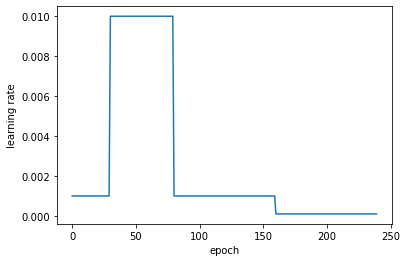

In [18]:
print('\nhistory lr:')
plt.figure()
plt.plot(np.arange(epochs), np.array(history.history['lr']))
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()


history val_loss:


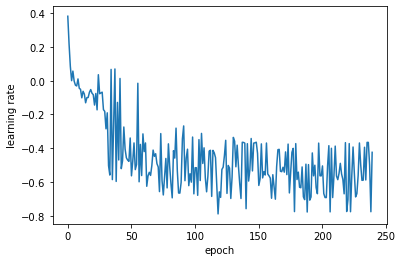

In [19]:
print('\nhistory val_loss:')
plt.figure()
plt.plot(np.arange(epochs), np.array(history.history['val_loss']))
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()


history val_mean_iou:


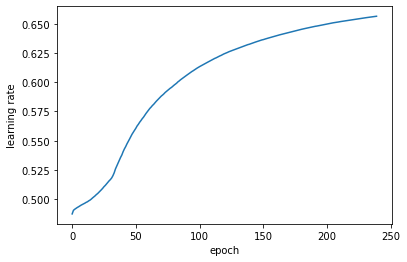

In [20]:
print('\nhistory val_mean_iou:')
plt.figure()
plt.plot(np.arange(epochs), np.array(history.history['val_mean_iou']))
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()

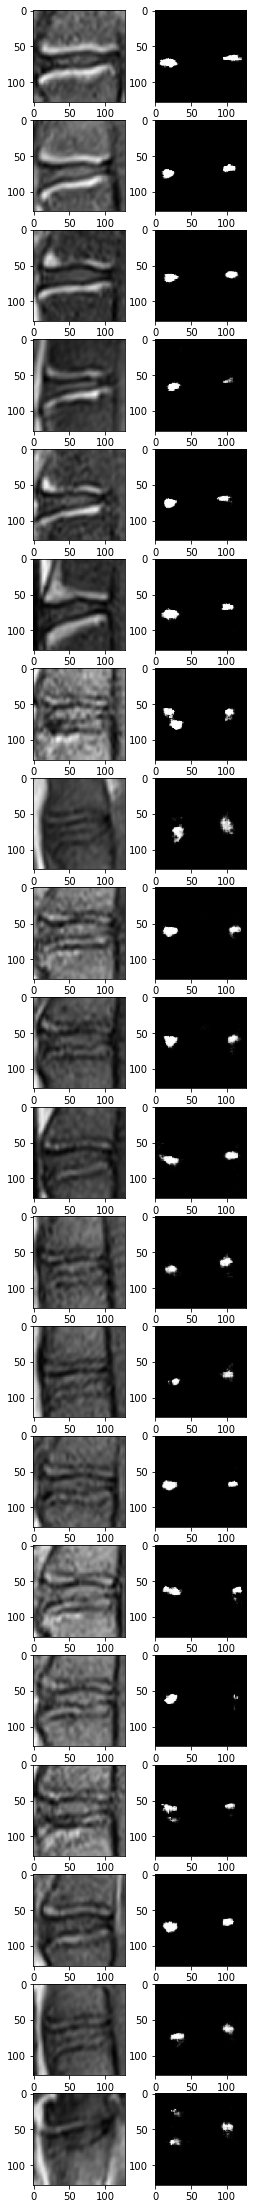

In [21]:
Y_pred = model2.predict(X_test_unlabelled)
X_test_show = np.squeeze(X_test_unlabelled)
Y_pred_show = np.squeeze(Y_pred)

plt.figure(figsize=(4,40))
for i in range(20):
    plt.subplot(20,2,2*(i+1)-1)
    plt.imshow(X_test_show[i,:,:],cmap = 'gray')
    plt.subplot(20,2,2*(i+1))
    plt.imshow(Y_pred_show[i,:,:],cmap = 'gray')
plt.show()

# further process: fetch ellipse

In [20]:
def draw_ellipse_side(input_im,input_pred):
    index_l = []
    index_r = []
    for i in range(10,30):
        for j in range(0,18):
            if input_pred[i,j] > 0.1:
                index_l.append([i,j])
    index_l = np.array(index_l)
    a = index_l[:,0]
    b = index_l[:,1]
    x_min = np.min(a)
    x_max = np.max(a)
    y_min = np.min(b)
    y_max = np.max(b)
    x_rayon_l = x_max-x_min
    y_rayon_l = y_max-y_min
    x_centre_l = (x_min+x_max)//2
    y_centre_l = (y_min+y_max)//2

    for i in range(10,30):
        for j in range(18,36):
            if input_pred[i,j] > 0.1:
                index_r.append([i,j])
    index_r = np.array(index_r)
    a = index_r[:,0]
    b = index_r[:,1]
    x_min = np.min(a)
    x_max = np.max(a)
    y_min = np.min(b)
    y_max = np.max(b)
    x_rayon_r = x_max-x_min
    y_rayon_r = y_max-y_min
    x_centre_r = (x_min+x_max)//2
    y_centre_r = (y_min+y_max)//2
    
    rr, cc=draw.ellipse_perimeter(x_centre_l, y_centre_l, x_rayon_l, y_rayon_l)
    draw.set_color(input_im,[rr,cc],[1])
    
    rr, cc=draw.ellipse_perimeter(x_centre_r, y_centre_r, x_rayon_r, y_rayon_r)
    draw.set_color(input_im,[rr,cc],[1])
    
    plt.imshow(input_im,cmap='gray')

IndexError: too many indices for array

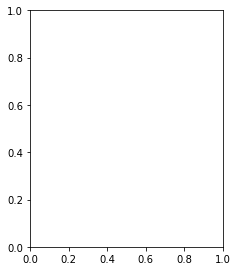

In [22]:
X_test_show_centre = X_test_show
Y_pred_show_centre = Y_pred_show
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(4,5,i+1)
    input_im = X_test_show_centre[i,:,:]
    input_pred = Y_pred_show_centre[i,:,:]
    draw_ellipse_side(input_pred,input_pred)
plt.show()

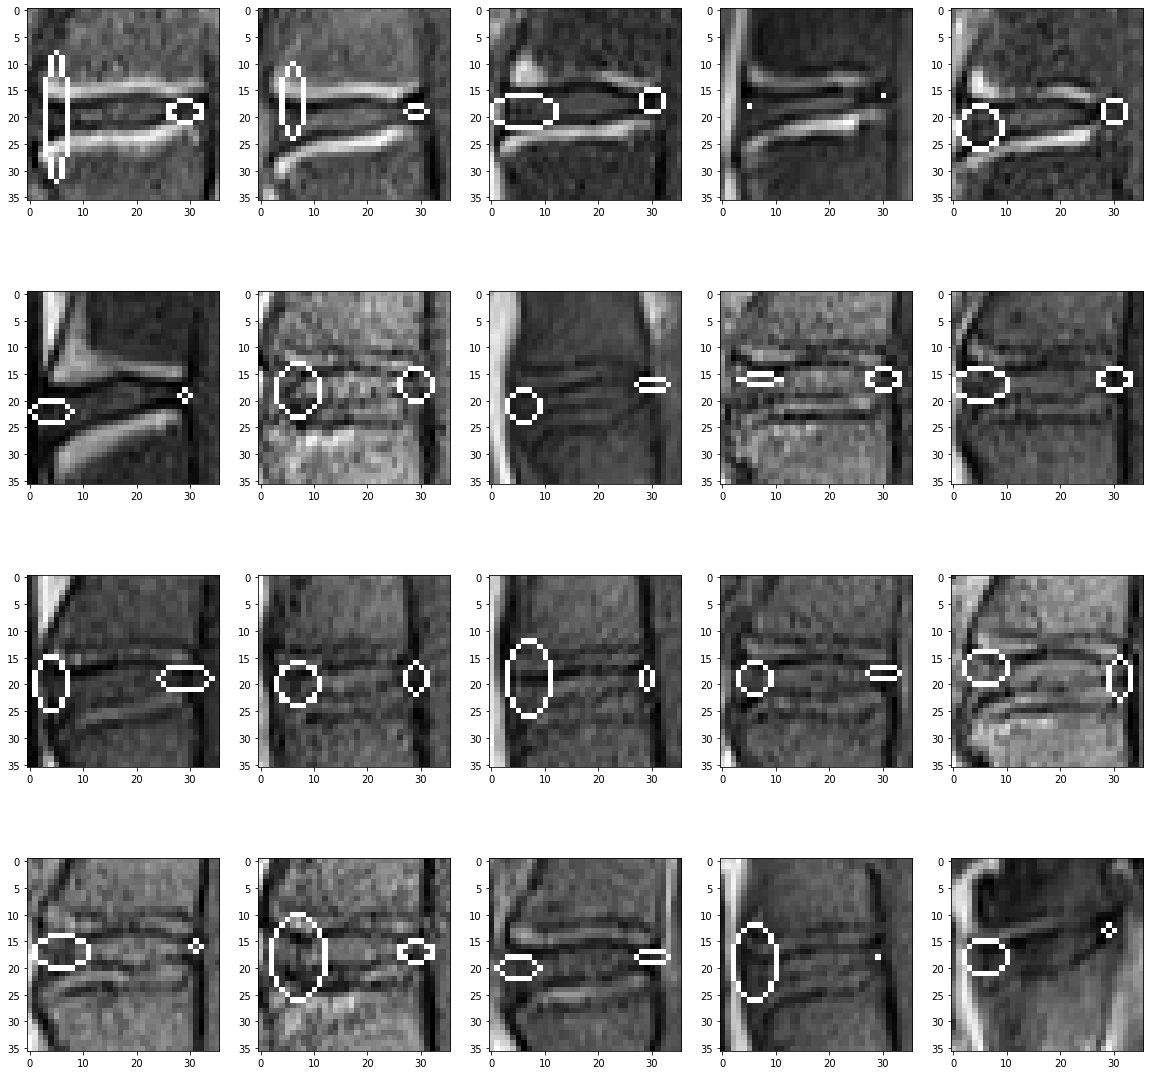

In [27]:
X_test_show_centre = X_test_show
Y_pred_show_centre = Y_pred_show
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(4,5,i+1)
    input_im = X_test_show_centre[i,:,:]
    input_pred = Y_pred_show_centre[i,:,:]
    draw_ellipse_side(input_im,input_pred)
plt.show()